## Bayesian optimization
To reproduce the experiments, first train the model on ZINC:
* `python train.py --config configs/zinc/vae_gaussian.ini --device cuda:0`
* `python train.py --config configs/zinc/vae_tricube.ini --device cuda:0`
* `python train.py --config configs/zinc/dd_vae_tricube.ini --device cuda:0`
* `python train.py --config configs/zinc/dd_vae_gaussian.ini --device cuda:0`

To reproduce Bayesian optimization, run the following script:
* `bash bo/run_experiment.sh models/zinc/VAE_GAUSSIAN/checkpoint.pt VAE_GAUSSIAN cuda:0`
* `bash bo/run_experiment.sh models/zinc/VAE_TRICUBE/checkpoint.pt VAE_TRICUBE cuda:0`
* `bash bo/run_experiment.sh models/zinc/DD_VAE_GAUSSIAN/checkpoint.pt DD_VAE_GAUSSIAN cuda:0`
* `bash bo/run_experiment.sh models/zinc/DD_VAE_TRICUBE/checkpoint.pt DD_VAE_TRICUBE cuda:0`

In [1]:
import numpy as np
import os
import gzip
import pickle
from rdkit import Chem
import cairosvg
from rdkit.Chem.Draw import IPythonConsole
from tqdm.auto import tqdm
import rdkit
from dd_vae.vae_rnn import VAE_RNN

from dd_vae.utils import prepare_seed
IPythonConsole.ipython_useSVG = True
rdkit.rdBase.DisableLog('rdApp.*')

RDKit WARNING: [11:07:42] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
def load_object(filename):
    with gzip.GzipFile(filename, 'rb') as source:
        result = source.read()
    ret = pickle.loads(result)
    source.close()
    return ret

In [3]:
def parse_folder(folder, th=3.5):
    smiles = []
    scores = []
    for i in range(5):
        smiles_path = os.path.join(folder, f'valid_smiles{i}.dat')
        if not os.path.exists(smiles_path):
            print(smiles_path)
            continue
        smiles.append(np.array(load_object(os.path.join(folder, f'valid_smiles{i}.dat'))))
        scores.append(-np.array(load_object(os.path.join(folder, f'scores{i}.dat'))))
    if len(smiles) != 0:
        smiles = np.concatenate(smiles)
        scores = np.concatenate(scores)
    else:
        smiles = np.array(smiles)
        scores = np.array(scores)
    if th is not None:
        smiles = smiles[scores > th]
        scores = scores[scores > th]
    order = np.argsort(-scores)
    smiles = smiles[order]
    scores = scores[order]
    with open(os.path.join(folder, 'log.txt')) as f:
        log = f.readlines()
    metrics = [x.strip() for x in log if x.startswith('Test')][-2:]
    if len(metrics) != 0:
        rmsd = float(metrics[0].split()[-1])
        ll = float(metrics[1].split()[-1])
    else:
        rmsd = np.nan
        ll = np.nan
    return smiles, scores, ll, rmsd        

In [4]:
def get_results(folder):
    all_smiles = []
    all_scores = []
    all_ll = []
    all_rmsd = []
    for i in range(1, 11):
        smiles, scores, ll, rmsd = parse_folder(f'bo/results/{folder}/experiment_{i}')
        all_smiles.append(smiles)
        all_scores.append(scores)
        all_ll.append(ll)
        all_rmsd.append(rmsd)
    print(f"LL: {np.mean(all_ll):0.3f}±{np.std(all_ll):0.3f}; "
          f"RMSD: {np.mean(all_rmsd):0.3f}±{np.std(all_rmsd):0.3f}")
    all_smiles = np.concatenate(all_smiles)
    all_scores = np.concatenate(all_scores)
    all_ll = np.array(all_ll)
    all_rmsd = np.array(all_rmsd)
    unique_idx = np.unique(all_smiles, return_index=True)[1]
    all_smiles = all_smiles[unique_idx]
    all_scores = all_scores[unique_idx]
    order = np.argsort(-all_scores)
    all_smiles = all_smiles[order]
    all_scores = all_scores[order]
    mols = [Chem.MolFromSmiles(x) for x in all_smiles]
    labels = [f"{x:0.2f}" for x in all_scores]
    svg = Chem.Draw.MolsToGridImage(mols[:50], legends=labels[:50], useSVG=True, molsPerRow=6)
    cairosvg.svg2pdf(bytestring=svg.data, write_to=f"images/zinc/{folder}_top50_molecules.pdf")
    for i in range(3):
        svg = Chem.Draw.MolsToGridImage([mols[i]], useSVG=True, molsPerRow=1)
        cairosvg.svg2pdf(bytestring=svg.data, write_to=f"images/zinc/{folder}_molecule_{i}.pdf")
    return Chem.Draw.MolsToGridImage(mols[:3], legends=labels[:3])

LL: -1.558±0.019; RMSD: 1.273±0.050


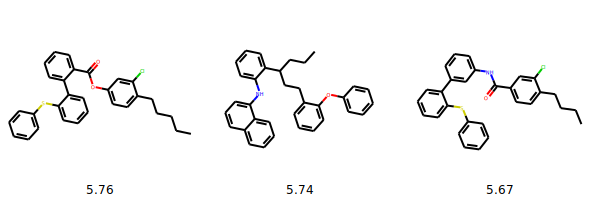

In [5]:
get_results('VAE_GAUSSIAN')

LL: -1.562±0.022; RMSD: 1.265±0.051


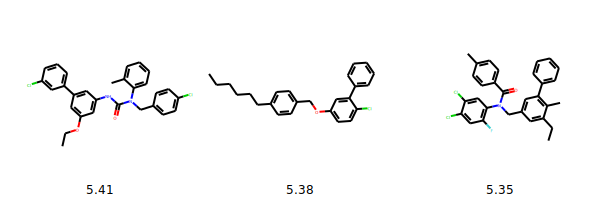

In [6]:
get_results('VAE_TRICUBE')

LL: -1.481±0.020; RMSD: 1.199±0.050


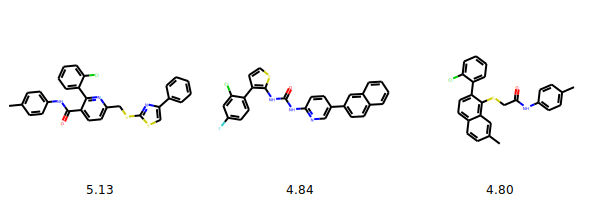

In [7]:
get_results('DD_VAE_GAUSSIAN')

LL: -1.470±0.022; RMSD: 1.186±0.053


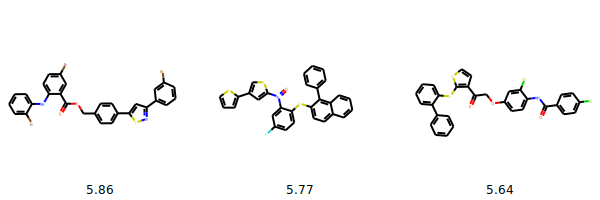

In [8]:
get_results('DD_VAE_TRICUBE')

## Validity
(We take reconstruction accuracy from Tensorboard)

In [9]:
model = VAE_RNN.load('models/zinc/VAE_GAUSSIAN/checkpoint.pt')
prepare_seed(1)
samples = sum([model.sample(100) for _ in tqdm(range(300))], [])
print("Validity:", np.mean([Chem.MolFromSmiles(x) is not None for x in samples]))


Validity: 0.7832333333333333


In [10]:
model = VAE_RNN.load('models/zinc/VAE_TRICUBE/checkpoint.pt')
prepare_seed(1)
samples = sum([model.sample(100) for _ in tqdm(range(300))], [])
print("Validity:", np.mean([Chem.MolFromSmiles(x) is not None for x in samples]))


Validity: 0.7352


In [11]:
model = VAE_RNN.load('models/zinc/DD_VAE_GAUSSIAN/checkpoint.pt')
prepare_seed(1)
samples = sum([model.sample(100) for _ in tqdm(range(300))], [])
print("Validity:", np.mean([Chem.MolFromSmiles(x) is not None for x in samples]))


Validity: 0.6306666666666667


In [12]:
model = VAE_RNN.load('models/zinc/DD_VAE_TRICUBE/checkpoint.pt')
prepare_seed(1)
samples = sum([model.sample(100) for _ in tqdm(range(300))], [])
print("Validity:", np.mean([Chem.MolFromSmiles(x) is not None for x in samples]))


Validity: 0.6137666666666667
